The goal here is to calculate the fraction of the baseline footprint vs. BigWFD footprint that can be observed with norther facilities (-20$\leq$dec$\leq$20).  We look at the two footprints with and without an extinciton cut (needed for extragalactic science).

In [1]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pickle
import healpy as hp
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.maps as maps
import lsst.sims.maf.metricBundles as metricBundles

# need some routines developed for LSSTDESC/ObsStrat/
import sys
sys.path.insert(0, '/global/homes/a/awan/LSST/lsstRepos/ObsStrat/code/modifyWFD/')
import helpers

# lets just ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
fontsize = 16
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['xtick.labelsize'] = fontsize-2
mpl.rcParams['ytick.labelsize'] = fontsize-2
mpl.rcParams['legend.fontsize'] = fontsize-2
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.titlesize'] = fontsize

**Set up**

In [3]:
fids_file = 'field_list.csv'   # in this repo

outdir = '/global/cscratch1/sd/awan/lsst_output/moar_area_output/'

# data dir for DESI footprint
# saved by the notebooks in LSSTDESC/ObStrat/static/depth_cuts/overlaps
footprint_dir = '/global/homes/a/awan/desc/4most-tides_desi_data/'

# path + tags to read in coadd data for the dbs; saved data has masks for each band.
file_yearTag = 'fullSurveyPeriod'
coadd_data_dir = '/global/cscratch1/sd/awan/lsst_output/coadd_output_noDith/'

bands = ['u', 'g', 'r', 'i', 'z', 'y']

# path to the baseline database
dbpath = '/global/cscratch1/sd/awan/dbs_wp_unzipped/baseline2018a.db'

**Read in the fields list**

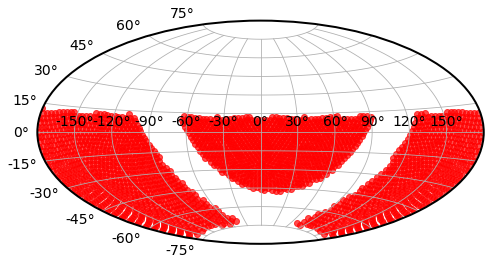

In [4]:
# Read the field list.
fields = pd.read_csv(fids_file)
# Select fields with declination between -90 and 32 -- our "big sky" footprint
wfd = fields.query('(dec >= -72.25) and (dec <= 12.4) and ((gb >= 15) or (gb <= -15))')

# Plot the fields so we can check what this footprint looks like.
def radec2project(ra, dec):
    return (np.radians(ra) - np.pi, np.radians(dec))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection="aitoff")
x, y = radec2project(wfd.ra, wfd.dec)
ax.scatter(x, y, alpha=0.7, color='r')
plt.grid(True)
plt.show()

**Read in the mapping between fieldIds and HEALPix pixels (saved by get_fov_pixels)**

In [5]:
file = [f for f in os.listdir(outdir) if f.endswith('.pickle') and f.__contains__('und')][0]
print('Reading in %s:'%file)
nside = int(file.split('nside')[-1].split('.pickle')[0])
print('Nside: %s'%nside)
pix_fov_dict = pickle.load(open('%s/%s'%(outdir, file), "rb"))
pix_fov_dict.pop('meta')

# get the healpix pixels for all the fieldsIDs in BigWFD
pix_list = []
for fid in wfd.fieldId:
    pix_list += pix_fov_dict[fid]
pix_list = np.unique(pix_list)

# save the pixel list
footprint_pixels = {}
footprint_pixels['BigWFD'] = pix_list

Reading in pixels_in_fov_undithered_nside256.pickle:
Nside: 256


**Read in the baseline2018a coadd data to find all-band footprint**

In [6]:
dbname = 'baseline2018a'
# Read in the coadd data for the db
data_bundle = {}   
for band in bands:
    # set up the folders
    folder = 'coaddM5Analysis_nside%s_withDustExtinction_'%(nside)
    folder += '0pixelRadiusForMasking_%sBand_%s_%s_directory/'%(band, dbname, file_yearTag)
    path = '%s/%s/unmaskedCoaddData/'%(coadd_data_dir, folder)
    # get the filenames
    filenames = [f for f in os.listdir(path) if f.endswith('.npz')]
    print('Reading %s from\n%s/unmaskedCoaddData.\n'%(filenames, folder))

    if len(filenames)>1:
        err = 'Have more than one npz file for %s band'%band
        err += ' for %s data: %s'%(yr_cut, filenames)
        raise ValueError(err)
    else:
        dither = filenames[0].split('%s_'%band)[-1]
        dither = dither.split('.npz')[0]
        mB = metricBundles.createEmptyMetricBundle()
        mB.read('%s/%s'%(path, filenames[0]))
        data_bundle['%s'%(band)]= mB

# find all-band footprint
all_band_pixels = None

for band in data_bundle:
    index = np.where((data_bundle[band].metricValues.mask == False) & \
                     (data_bundle[band].metricValues.data > 0))[0]
    # save the indices
    if all_band_pixels is None:
        # initate the list
        all_band_pixels = index
    else:
        # keep only the overlapping pixels
        all_band_pixels = list(set(all_band_pixels).intersection(index))

footprint_pixels['all-band %s'%dbname] = np.array(all_band_pixels)

Reading ['coaddM5Data_unmasked_u_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_uBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_g_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_gBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_r_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_rBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Reading ['coaddM5Data_unmasked_i_NoDither.npz'] from
coaddM5Analysis_nside256_withDustExtinction_0pixelRadiusForMasking_iBand_baseline2018a_fullSurveyPeriod_directory//unmaskedCoaddData.

Healpix slicer using

**Construct an ebv to include extinction-limited statistics**

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


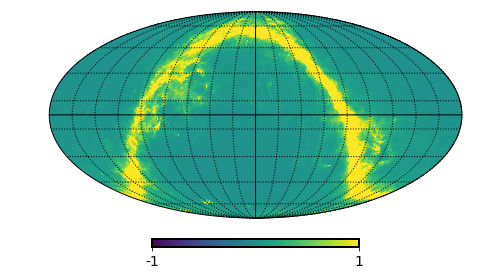

CPU times: user 13.4 s, sys: 2.16 s, total: 15.6 s
Wall time: 15.4 s


In [7]:
%%time
# import EBV map from MAF
opsdb = db.OpsimDatabase(dbpath)
simdata = opsdb.fetchMetricData(['fieldId', 'fieldRA', 'fieldDec', 'night'],  # assume v4 outputs: fieldID in v3
                                sqlconstraint=None)

slicer = slicers.HealpixSlicer(lonCol='fieldRA',
                                   latCol='fieldDec',
                                   latLonDeg=opsdb.raDecInDeg, nside=nside)

# set up dust map to get the ebv map
dustmap = maps.DustMap(nside=nside)
slicer.setupSlicer(simdata)
result = dustmap.run(slicer.slicePoints)
ebv_map = result['ebv']

# plot to see things
helpers.plot_skymap(ebv_map, cmin=-1, cmax=1)

**Find the area between -20<dec<20 with and without a limit on E(B-V)**

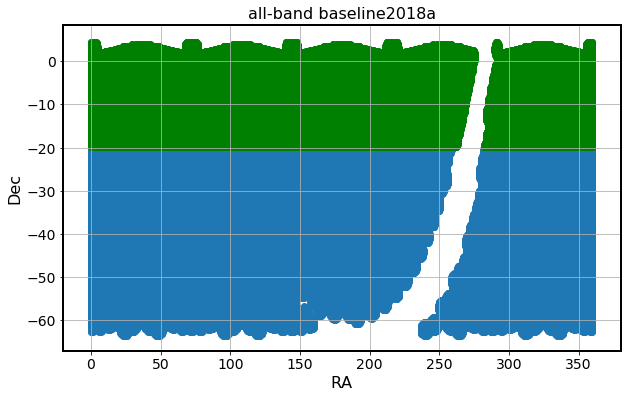

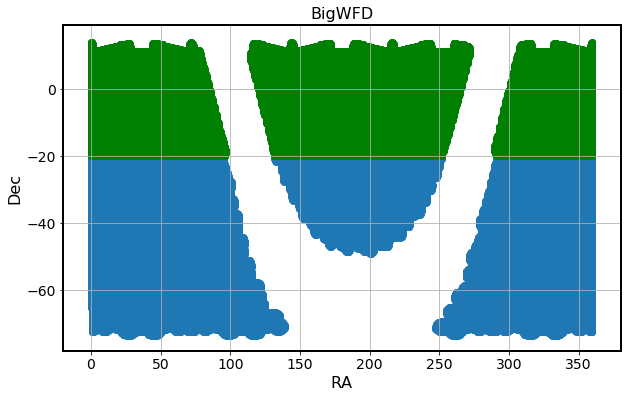

| footprint | Total Area (deg$^2$) | Area in -20$^{\circ}$ $\leq$ dec $\leq$ 20$^{\circ}$ (deg$^2$) |  Total Area with EBV<0.2 (deg$^2$) |  Area in -20$^{\circ}$ $\leq$ dec $\leq$ 20$^{\circ}$ with EBV<0.2 (deg$^2$) | 
| ------ | ------ | ------ | ------ | ------ |
| all-band baseline2018a | 18034 | 7789 | 14696 (81.49% of all-total) | 6265 |
| BigWFD | 18038 | 9277 | 16909 (93.74% of all-total) | 8396 |



In [8]:
ebv_lim = 0.2
min_dec, max_dec = -20, 20
header = '| footprint | Total Area (deg$^2$) |'
header += ' Area in %s$^{\circ}$ $\leq$ dec $\leq$ %s$^{\circ}$ (deg$^2$) | '%(min_dec, max_dec)
header += ' Total Area with EBV<%s (deg$^2$) | '%(ebv_lim)
header += ' Area in %s$^{\circ}$ $\leq$ dec $\leq$ %s$^{\circ}$ with EBV<%s (deg$^2$) | '%(min_dec, max_dec, ebv_lim)
header2 = '| ------ | ------ | ------ | ------ | ------ |'

ebv_ind = np.where(ebv_map<0.2)[0]

rows = ''
# plot the ra, dec corresponding on the all-band pixels
for key in ['all-band %s'%dbname, 'BigWFD']:
    ras, decs = helpers.pix_to_radec(pixels=footprint_pixels[key], nside=nside)
    
    ind_dec_limit = np.where((decs<=max_dec) & (decs>=min_dec))[0]
    # plot the ra, dec for clarity
    plt.clf()
    plt.scatter(ras, decs, )
    plt.scatter(ras[ind_dec_limit], decs[ind_dec_limit], color='g', label='%s <= dec <= %s'%(min_dec, max_dec))
    plt.title(key)
    plt.xlabel('RA')
    plt.ylabel('Dec')
    plt.show()
    
    # lets get the total area and area of the region in the dec limits
    tot0 = helpers.get_area(footprint_pixels[key], nside)
    subsample0 = helpers.get_area(footprint_pixels[key][ind_dec_limit], nside)

    rows += '| %s | %.f | %.f '%(key, tot0, subsample0)
    
    # lets now focus on the pixels that have EVC<ebv_limit
    # ebv-limited ones in the total area
    ebv_pix = np.array(list(set(footprint_pixels[key]) - \
                            (set(footprint_pixels[key]) - set(ebv_ind))))
    tot = helpers.get_area(ebv_pix, nside)
    
    # ebv-limited ones in the dec-limited area
    ebv_pix = np.array(list(set(footprint_pixels[key][ind_dec_limit]) - \
                            (set(footprint_pixels[key][ind_dec_limit]) - set(ebv_ind))))
    subsample = helpers.get_area(ebv_pix, nside)
    
    rows += '| %.f (%.2f%% of all-total) | %.f |\n'%(tot, 100.*tot/tot0, subsample)

print('%s\n%s\n%s'%(header, header2, rows)) 

| footprint | Total Area (deg$^2$) | Area in -20$^{\circ}$ $\leq$ dec $\leq$ 20$^{\circ}$ (deg$^2$) |  Total Area with EBV<0.2 (deg$^2$) |  Area in -20$^{\circ}$ $\leq$ dec $\leq$ 20$^{\circ}$ with EBV<0.2 (deg$^2$) | 
| ------ | ------ | ------ | ------ | ------ |
| all-band baseline2018a | 18034 | 7789 | 14696 (81.49% of all-total) | 6265 |
| BigWFD | 18038 | 9277 | 16909 (93.74% of all-total) | 8396 |